In [48]:
import os
import math

import numpy as np
import pandas as pd
import plotly.express as px

from matplotlib import pyplot as plt

# The Odds
The odds of winning the lottery aren't great, there are 292,201,338 possible unique ticket combinations for the powerball based on the rules of the game (math code below) but that's for the jackpot. The actual odds of winning the game are about 1 / 25 (or 4%) given there are a number of different combitations that yield prizes.

Granted most of us are here for the big money so let's focus on that sweet jackpot!

In [25]:
odds = (math.factorial(5) / (math.factorial(69) / math.factorial(64))) * (1 / 26)
print("Odds of winning {:.3f}".format(odds))
print("Odds of winning 1 in {:.0f}".format(1 / odds))

Odds of winning 0.000
Odds of winning 1 in 292201338


Those odds are low, sad! The odds are valid assuming the drawings are completely random (it's worth noting that drawings are completely random) _but_ assuming there is some pattern or method in how numbers are drawn each time we could in theory predict drawings based on historic results.

This is where awful intelligence (AI) comes into play, we can collect historic drawings data and construct the prophet of our dreams to predict what the next lottery drawing will be!

To start we'll need historic drawing data, I'm using data from the website (catalog.data.gov)[https://catalog.data.gov/dataset/lottery-powerball-winning-numbers-beginning-2010] and will trust it since I'm too lazy to go find another source or validate this one.

In [62]:
df = pd.read_csv(os.path.join('/'.join(os.getcwd().split('/')[:-1]), 'data/Lottery_Powerball_Winning_Numbers__Beginning_2010.csv'))
df.head()

,Draw Date,Winning Numbers,Multiplier
0,09/26/2020,11 21 27 36 62 24,3.0
1,09/30/2020,14 18 36 49 67 18,2.0
2,10/03/2020,18 31 36 43 47 20,2.0
3,10/07/2020,06 24 30 53 56 19,2.0
4,10/10/2020,05 18 23 40 50 18,3.0


Perfect! Well almost, this data is still unnusable for a model and is hard to get insights from. For starters we don't care about the multiplier since we're aiming for the big prize!

In [63]:
for i in range(6):
    df['number_{}'.format(i+1)] = df['Winning Numbers'].apply(lambda x: x.split()[i]).astype(int)
df.rename(columns={"number_6": "powerball"}, inplace=True)
df = df.drop(['Winning Numbers', 'Multiplier'], axis=1)
df['Draw Date'] = pd.to_datetime(df['Draw Date'])
df.head()

,Draw Date,number_1,number_2,number_3,number_4,number_5,powerball
0,2020-09-26,11,21,27,36,62,24
1,2020-09-30,14,18,36,49,67,18
2,2020-10-03,18,31,36,43,47,20
3,2020-10-07,6,24,30,53,56,19
4,2020-10-10,5,18,23,40,50,18


Now that's looking much better! We can even grab some quick statistics about numbers and drawings with the data formatted as it is.

In [39]:
df.describe()

,number_1,number_2,number_3,number_4,number_5,powerball
count,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000
mean,11.460485,22.155569,33.583696,44.641568,55.225264,15.459241
std,9.237399,11.538152,12.449712,12.082673,10.182104,9.149277
min,1.000000,2.000000,3.000000,7.000000,19.000000,1.000000
25%,4.000000,13.000000,24.000000,37.000000,49.000000,8.000000
50%,9.000000,21.000000,34.000000,46.000000,57.000000,15.000000
75%,16.000000,30.000000,42.000000,54.000000,63.000000,23.000000
max,52.000000,61.000000,65.000000,68.000000,69.000000,39.000000


There's some structure to how numbers are stored within columns, generally numbers increase going from 1-5. To get a better sense of distributions we'll need to make some adjustments.

We'll start by splitting the 5 picked numbers from the powerball itself to better understand how drawing numbers are distributed over time.

In [64]:
# Create array of draw numbers
df['numbers_array'] = df.apply(lambda x: np.array([x['number_{}'.format(i+1)] for i in range(5)]), axis=1)

# Average mean
avg_avg = df.apply(lambda x: x['numbers_array'].mean(), axis=1).mean()
print("Average mean {:.2f}".format(avg_avg))

# Average max
avg_max = df.apply(lambda x: x['numbers_array'].max(), axis=1).mean()
print("Average max {:.2f}".format(avg_max))

# Average min
avg_min = df.apply(lambda x: x['numbers_array'].min(), axis=1).mean()
print("Average min {:.2f}".format(avg_min))

Average mean 33.41
Average max 55.24
Average min 11.46


The summaries match what we observed for the drawing number 1 and number 5, supposedly drawing numbers are ordered least to greatest with number 1 being the min and number 5 being the max, but it's good to validate these assumptions with some brute force.

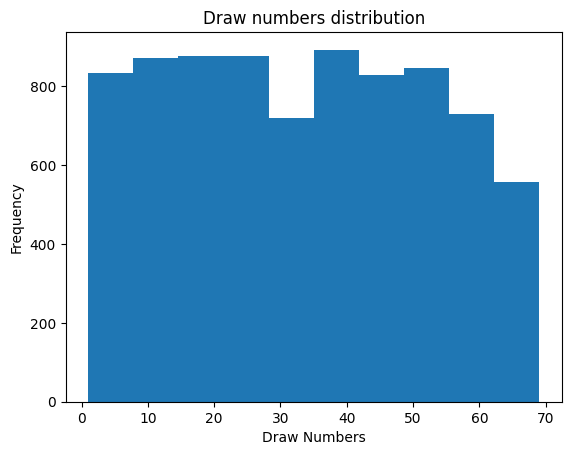

In [65]:
# Raw draw numbers distribution
draw_numbers = df['numbers_array'].apply(lambda x: pd.Series(x)).stack().reset_index(drop=True)
plt.hist(draw_numbers)
plt.xlabel("Draw Numbers")
plt.ylabel("Frequency")
plt.title("Draw numbers distribution")
plt.show()

It looks like there are some numbers that are less likely to be drawn than others, this is important to know when considering how to pick numbers since a completely random approach may not work well if certain numbers are less likely to appear than others.

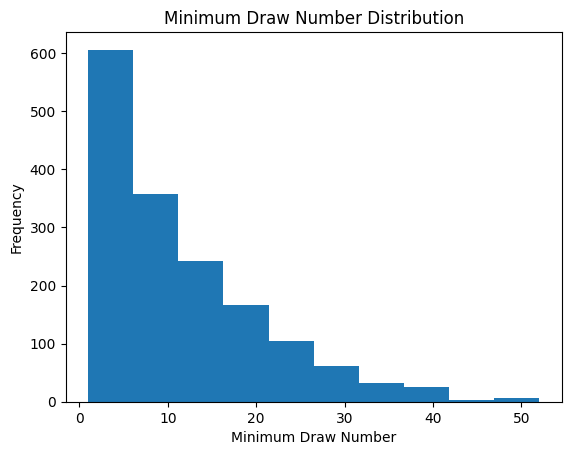

In [50]:
# Minimum draw number distribution
plt.hist(df.apply(lambda x: x['numbers_array'].min(), axis=1))
plt.ylabel('Frequency')
plt.xlabel('Minimum Draw Number')
plt.title('Minimum Draw Number Distribution')
plt.show()

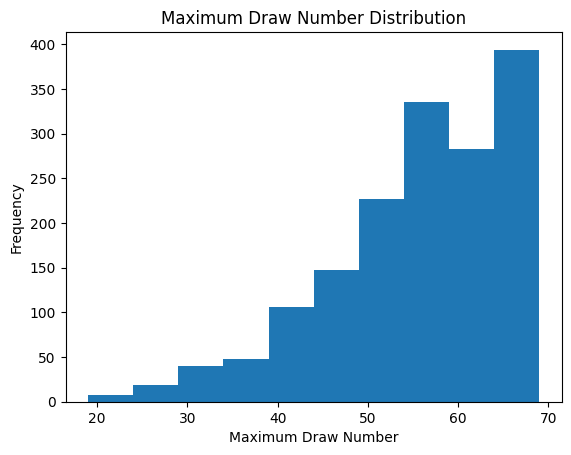

In [51]:
# Maximum draw number distribution
plt.hist(df.apply(lambda x: x['numbers_array'].max(), axis=1))
plt.ylabel('Frequency')
plt.xlabel('Maximum Draw Number')
plt.title('Maximum Draw Number Distribution')
plt.show()

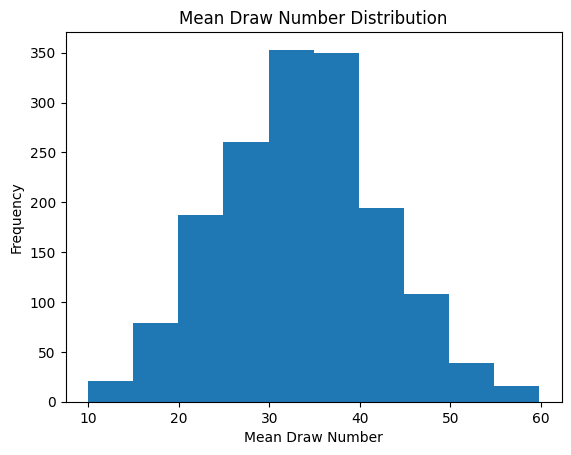

In [52]:
# Mean draw number distribution
plt.hist(df.apply(lambda x: x['numbers_array'].mean(), axis=1))
plt.ylabel('Frequency')
plt.xlabel('Mean Draw Number')
plt.title('Mean Draw Number Distribution')
plt.show()

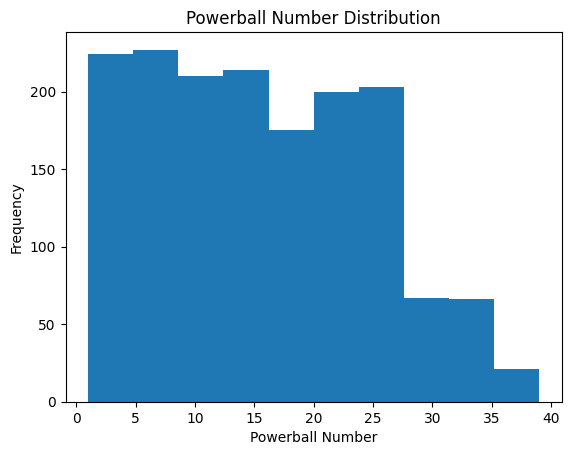

In [53]:
# Powerball number distribution
plt.hist(df['powerball'])
plt.ylabel('Frequency')
plt.xlabel('Powerball Number')
plt.title('Powerball Number Distribution')
plt.show()

The number distributions make sense for the most part, the powerball draws are strange as the number should only go to 26 (rules may have changed over time though).

In [66]:
fig = px.scatter(df, x='Draw Date', y='powerball', title='Powerball Number Distribution')
fig.show()

Around 2016 the the powerball itself seems to have capped at 26 (which is what the website rules state). With this we have just about everything needed for starting to predict lottery drawings! Numbers appear mostly uniform in distribution, and so long as we focus on powerball picks after 2016 they should line up to modern drawings fairly well.

So how do we model thew lottery drawings?

There are several approaches that work for trying to predict number drawings but let's consider the scenario and then appropriate models from there.
1. 5 numbers without repeat are draw from 1-69, 1 number from 1-26 is drawn as the powerball
2. We have about 8 years worth of data that follow the current rules format

So the goal is to get 5 numbers from the general drawing pool and then 1 powerball number. We could employe several strategies to reach this goal such as:
1. Picking only numbers that haven't been picked in the last 3 drawings
2. Picking numbers based on the day of the week/year (if it's Tuesday why not pick a few twos?)
3. Picking numbers based on observed historic trends.
4. ...


Case 1 has a few issues, assuming drawings are random there's sure to be times when avoiding repeats will hurt our odds of winning not improve them. Case 2 is interesting, looking at the data the drawings do appear to be fairly random but not having analyzed by day of week or time of year this could be a viable strategy (if there is a case where certain numbers are more likely at times then it could be a good strategy). Case 3 is probably the method to beat though, rather than trying to pick out trends ourselves we can let an ML algorithm pick out "the best" strategy from historic data. 

We'll be using a neural network, a recurrent neural network, model to accomplish the goal of predicting future lottery drawings. There are several predictive model approaches that work here, but given we need to chose 5 out of 69 numbers and then an additional 1 out of 26 numbers, the RNN is the least cumbersome to implement.

In [174]:
import torch
import torch.nn as nn

# Get device for training models
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
df_sub = df.loc[df['Draw Date'] > '2016-01-01']
print(f'Rows before subsetting: {len(df)}')
print(f'Rows after subsetting: {len(df_sub)}')
df_sub.sort_values('Draw Date', inplace=True, ascending=False)
df_sub.reset_index(drop=True, inplace=True)

Using mps device
Rows before subsetting: 1607
Rows after subsetting: 991


/var/folders/gb/xn1wfspj0rb7nzzm7rp1m6qw0000gn/T/ipykernel_21223/2733230666.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [216]:
import torch
import torch.nn as nn

from torch.nn import LSTM, RNN

# Get device for training models
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Create input tensors from data
model_inputs = []
for i in range(df_sub.shape[0]):
    temp_list = list(df_sub.loc[i, 'numbers_array'] - 1)
    temp_list.append(df_sub.loc[i, 'powerball'] + 69 - 1)
    model_inputs.append(temp_list)

# Convert inputs to one-hot encoded tensors
def one_hot_encode(numbers, max_number):
    one_hot = torch.zeros(max_number)
    for number in numbers:
        one_hot[number] = 1
    return one_hot

model_inputs = torch.stack([one_hot_encode(numbers, 69+26) for numbers in model_inputs])

# Create target and inputs for model
seq_len = 60
y = []
x = []
for i in range(seq_len, len(model_inputs)):
    x.append(model_inputs[i - seq_len:i])
    y.append(model_inputs[i])

# Create training and testing data
x_train = x[:-seq_len]
x_test = x[-seq_len:]
y_train = y[:-seq_len]
y_test = y[-seq_len:]

# Create model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.sigmoid(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Convert the training data to tensors
x_train = torch.stack(x_train).to(device)
y_train = torch.stack(y_train).to(device)

Using mps device


There's a few things happening here worth explaining, the powerball number can be thought of different extension of the existing numbers, rather than calling a powerball with a value of 1 just 1 we can map it to 70 since that isn't a number in use. This will help when modeling the sequences of historic drawings as the model will have an easier time handling the values.

In [230]:
# Initialize the RNN model
n_hidden = 128
rnn = RNN(x_train[0].shape[0] * x_train[0].shape[1], n_hidden, len(x_train[0][0])).to(device)

# Set the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

# Set the number of epochs
epochs = 100

# Train the RNN model
for epoch in range(epochs):
    hidden = rnn.initHidden().to(device)
    rnn.zero_grad()
    loss = 0

    for i in range(len(x_train)):
        input_seq = x_train[i].to(device)
        input_seq = torch.flatten(input_seq)
        input_seq = input_seq.unsqueeze(0)  # Reshape the input sequence
        target_seq = y_train[i].to(device)
        output, hidden = rnn(input_seq, hidden)
        loss += criterion(output.squeeze(), target_seq)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

print("Training completed!")

Epoch: 0, Loss: 602.6051025390625
Epoch: 10, Loss: 217.3876953125
Epoch: 20, Loss: 189.53955078125
Epoch: 30, Loss: 170.83953857421875
Epoch: 40, Loss: 154.19813537597656
Epoch: 50, Loss: 137.5348358154297
Epoch: 60, Loss: 121.01409149169922
Epoch: 70, Loss: 104.82257080078125
Epoch: 80, Loss: 89.41764068603516
Epoch: 90, Loss: 75.20662689208984
Training completed!


So what just happened in the notebook? The RNN tried to go through and create a general heuristic for guessing what the next power ball drawing should be given a historic set of 60 prior drawings. This all sounds pretty cool, but for this to work there does need to be some underlying pattern in the data that can generalize to future drawings. We can evaluate how good the prophet is by looking at our holdout set, or a period of drawings the model has not had the chance to view and see how well it does at predicting those.

In order to make a prediction the model requires 60 previous drawings and will then attempt to predict the next drawing.

In [257]:
for i in range(len(x_test)):
    # Iterate through test set and display predicitons vs observed

    # Predictions
    input_seq = x_test[i].to(device)
    input_seq = torch.flatten(input_seq)
    input_seq = input_seq.unsqueeze(0)  # Reshape the input sequence
    output, hidden = rnn(input_seq, hidden)
    topk_values, predicted_draws = torch.topk(output.squeeze()[:69], k=5)
    predicted_draws = [int(value) + 1 for value in predicted_draws]
    predicted_draws.sort()
    topk_values, predicted_powerball = torch.topk(output.squeeze()[69:], k=1)
    predicted_powerball = int(predicted_powerball) + 1
    predicted_ticket = predicted_draws + [predicted_powerball]

    # Observed
    topk_values, observed_draws = torch.topk(y_test[i][:69], k=5)
    observed_draws = [int(value) + 1 for value in observed_draws]
    observed_draws.sort()
    topk_values, observed_powerball = torch.topk(y_test[i][69:], k=1)
    observed_powerball = int(observed_powerball) + 1
    observed_ticket = observed_draws + [observed_powerball]

    print(f'Prediccted: {predicted_ticket}, Obsesrved: {observed_ticket}')

Prediccted: [18, 37, 39, 44, 62, 26], Obsesrved: [10, 47, 50, 65, 68, 24]
Prediccted: [23, 28, 54, 59, 64, 2], Obsesrved: [5, 7, 23, 35, 39, 11]
Prediccted: [21, 45, 49, 53, 56, 18], Obsesrved: [6, 25, 35, 58, 66, 5]
Prediccted: [11, 28, 50, 62, 67, 12], Obsesrved: [11, 17, 40, 50, 62, 26]
Prediccted: [24, 51, 54, 68, 69, 24], Obsesrved: [3, 15, 29, 54, 57, 10]
Prediccted: [1, 16, 56, 58, 69, 24], Obsesrved: [10, 28, 32, 61, 64, 12]
Prediccted: [6, 17, 24, 37, 63, 21], Obsesrved: [2, 24, 31, 57, 66, 18]
Prediccted: [8, 9, 35, 53, 58, 14], Obsesrved: [10, 34, 39, 59, 63, 4]
Prediccted: [3, 20, 61, 63, 69, 24], Obsesrved: [23, 29, 37, 60, 64, 6]
Prediccted: [15, 28, 32, 63, 67, 4], Obsesrved: [3, 27, 36, 56, 69, 25]
Prediccted: [3, 29, 37, 44, 54, 21], Obsesrved: [14, 40, 42, 43, 52, 17]
Prediccted: [27, 38, 54, 58, 61, 18], Obsesrved: [2, 23, 41, 53, 63, 11]
Prediccted: [9, 20, 40, 54, 61, 14], Obsesrved: [4, 22, 24, 31, 33, 10]
Prediccted: [8, 14, 24, 28, 63, 24], Obsesrved: [20, 27, 3

A quick glance at the model results reveal it isn't a very good prophet, so what gives? Well if this were a more reasonable problem to solve we might start looking at improving the model by training more, introducing a validation set during training, changing up the algorith structure, or reimagining the model framework.

Looking at the predicted tickets and seeing the numbers come out is as far as this can go so we'll call it quits here and rely on other methods of divination to pick those lucky numbers next time.